In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split

2026-02-24 17:50:11.480031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771955411.602475      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771955411.640215      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771955411.908676      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771955411.908715      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771955411.908718      23 computation_placer.cc:177] computation placer alr

In [2]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
BATCH_SIZE = 4
EPOCHS = 25
LEARNING_RATE = 1e-4
NUM_CLASSES = 20  # exclude void class

AUTOTUNE = tf.data.AUTOTUNE
DATASET_ROOT = "/kaggle/input/datasets/sajilck/road-segmentation-indian"

In [3]:
CLASS_MAP = {
    "road": 0,
    "sidewalk": 1,
    "building": 2,
    "wall": 3,
    "fence": 4,
    "pole": 5,
    "traffic light": 6,
    "traffic sign": 7,
    "vegetation": 8,
    "terrain": 9,
    "sky": 10,
    "person": 11,
    "rider": 12,
    "car": 13,
    "truck": 14,
    "bus": 15,
    "train": 16,
    "motorcycle": 17,
    "bicycle": 18,
    # void removed
}

In [4]:
CSV_PATH = os.path.join(DATASET_ROOT, "data/index.csv")
df = pd.read_csv(CSV_PATH)[["images", "masks"]]

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    df["images"],
    df["masks"],
    test_size=0.2,
    random_state=42)

In [5]:
def json_to_mask(json_path, height, width):
    mask = np.zeros((height, width), dtype=np.uint8)

    with open(json_path) as f:
        data = json.load(f)

    for obj in data.get("objects", []):

        label = obj.get("label", None)
        if label not in CLASS_MAP:
            continue

        polygon = obj.get("polygon", None)

        # 🔹 Skip invalid polygons
        if polygon is None:
            continue

        if len(polygon) < 3:
            continue

        try:
            polygon = np.array(polygon, dtype=np.int32)

            # Ensure correct shape (N, 2)
            if polygon.ndim != 2 or polygon.shape[1] != 2:
                continue

            cv2.fillPoly(mask, [polygon], CLASS_MAP[label])

        except Exception:
            continue  # Skip corrupted polygons silently

    return mask

In [6]:
def load_image_mask(image_path, mask_path):

    image_path = image_path.decode("utf-8")
    mask_path = mask_path.decode("utf-8")

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    orig_h, orig_w = image.shape[:2]
    mask = json_to_mask(mask_path, orig_h, orig_w)

    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT),
                      interpolation=cv2.INTER_NEAREST)

    image = image / 255.0

    return image.astype(np.float32), mask.astype(np.int32)

In [7]:
def tf_load(image_path, mask_path):
    image, mask = tf.numpy_function(
        load_image_mask,
        [image_path, mask_path],
        [tf.float32, tf.int32]
    )
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH])
    return image, mask

In [8]:
def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)

        # Expand mask to 3D
        mask = tf.expand_dims(mask, axis=-1)
        mask = tf.image.flip_left_right(mask)
        mask = tf.squeeze(mask, axis=-1)

    return image, mask

In [9]:
def build_dataset(image_paths, mask_paths, training=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(tf_load, num_parallel_calls=AUTOTUNE)

    if training:
        dataset = dataset.map(augment, num_parallel_calls=AUTOTUNE)
        dataset = dataset.shuffle(100)

    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

In [10]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_unet():
    inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, 3))

    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D()(c3)

    c4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D()(c4)

    c5 = conv_block(p4, 512)

    u6 = layers.Conv2DTranspose(256, 2, strides=2, padding="same")(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = conv_block(u6, 256)

    u7 = layers.Conv2DTranspose(128, 2, strides=2, padding="same")(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = conv_block(u7, 128)

    u8 = layers.Conv2DTranspose(64, 2, strides=2, padding="same")(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = conv_block(u8, 64)

    u9 = layers.Conv2DTranspose(32, 2, strides=2, padding="same")(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = conv_block(u9, 32)

    outputs = layers.Conv2D(NUM_CLASSES, 1, activation="softmax")(c9)

    return models.Model(inputs, outputs)

In [11]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, depth=NUM_CLASSES)

    y_true = tf.reshape(y_true, [-1, NUM_CLASSES])
    y_pred = tf.reshape(y_pred, [-1, NUM_CLASSES])

    intersection = tf.reduce_sum(y_true * y_pred)

    return 1 - (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

def combined_loss(y_true, y_pred):
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return ce + dl

In [12]:
mean_iou = tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)

def compute_mean_iou(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    mean_iou.update_state(y_true, y_pred)
    return mean_iou.result()

I0000 00:00:1771955434.760998      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771955434.767129      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [13]:
class EarlyStopper(Callback):
    def __init__(self, target):
        super(EarlyStopper, self).__init__()
        self.target = target
    def on_epoch_end(self, epoch, logs={}):
        acc = logs['val_compute_mean_iou']
        if acc >= self.target:
            self.model.stop_training = True

In [14]:
early_stopper = EarlyStopper(0.8)

In [15]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor="val_compute_mean_iou",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_compute_mean_iou",
        mode="max",
        factor=0.5,
        patience=3,
        verbose=1
    ),
    early_stopper]

In [16]:
model = build_unet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    loss=combined_loss,
    metrics=[compute_mean_iou])

In [17]:
train_imgs = DATASET_ROOT+'/'+ train_imgs.astype(str)
train_masks = DATASET_ROOT+'/'+ train_masks.astype(str)
val_imgs = DATASET_ROOT+'/'+ val_imgs.astype(str)
val_masks = DATASET_ROOT+'/'+ val_masks.astype(str)

In [18]:
train_dataset = build_dataset(train_imgs, train_masks, training=True)
val_dataset = build_dataset(val_imgs, val_masks, training=False)

history = model.fit(train_dataset,
          validation_data=val_dataset,
          epochs=EPOCHS,
          callbacks=callbacks)

Epoch 1/25


I0000 00:00:1771955449.816514      67 service.cc:152] XLA service 0x793e700036d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771955449.816552      67 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771955449.816557      67 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771955452.057703      67 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-24 17:50:56.278427: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng12{k11=2} for conv %cudnn-conv-bias-activation.62 = (f32[4,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,128,128,128]{3,2,1,0} %bitcast.21817, f32[128,128,3,3]{3,2,1,0} %bitcast.17182, f32[128]{0} %bitcast.21877), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_5_1/convolution" s

801/802 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - compute_mean_iou: 0.0838 - loss: 2.4528

2026-02-24 17:56:09.162254: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-24 17:56:09.381430: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-24 17:56:10.177140: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-24 17:56:10.470463: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-24 17:56:13.846968: E external/local_xla/xla/stream_

802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - compute_mean_iou: 0.0838 - loss: 2.4521
Epoch 1: val_compute_mean_iou improved from -inf to 0.13242, saving model to best_model.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 390s 410ms/step - compute_mean_iou: 0.0839 - loss: 2.4513 - val_compute_mean_iou: 0.1324 - val_loss: 1.1186 - learning_rate: 1.0000e-04
Epoch 2/25
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - compute_mean_iou: 0.1359 - loss: 1.0907
Epoch 2: val_compute_mean_iou improved from 0.13242 to 0.14338, saving model to best_model.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 292s 361ms/step - compute_mean_iou: 0.1359 - loss: 1.0906 - val_compute_mean_iou: 0.1434 - val_loss: 0.8163 - learning_rate: 1.0000e-04
Epoch 3/25
802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - compute_mean_iou: 0.1457 - loss: 0.8486
Epoch 3: val_compute_mean_iou improved from 0.14338 to 0.15053, saving model to best_model.keras
802/802 ━━━━━━━━━━━━━━━━━━━━ 292s 361ms/step - compute_mean_iou: 0.1457 - loss: 0.8486 - val_compute_mean

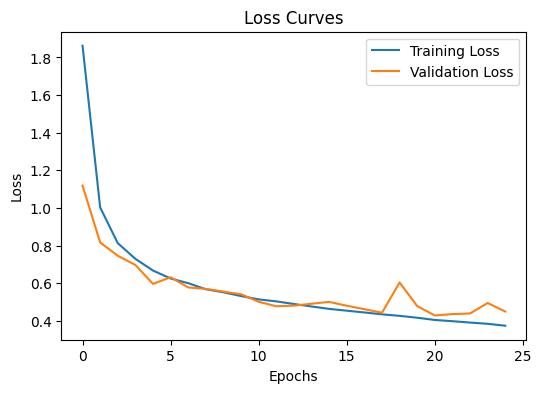

In [19]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

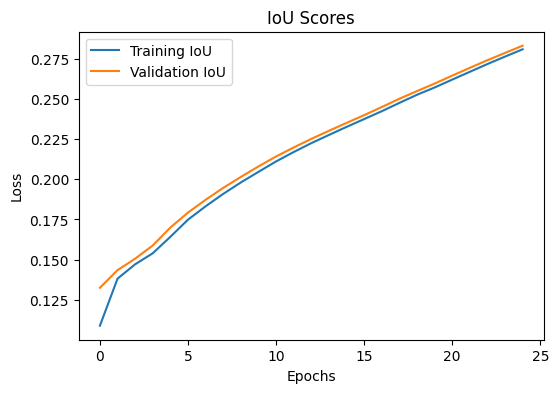

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['compute_mean_iou'], label='Training IoU')
plt.plot(history.history['val_compute_mean_iou'], label='Validation IoU')
plt.title('IoU Scores')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
def load_image_mask2(image_path, mask_path):

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    orig_h, orig_w = image.shape[:2]
    mask = json_to_mask(mask_path, orig_h, orig_w)

    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT),
                      interpolation=cv2.INTER_NEAREST)

    image = image / 255.0

    return image.astype(np.float32), mask.astype(np.int32)

In [22]:
def visualize_sample(index=0):

    image_path = val_imgs.values[index]
    mask_path = val_masks.values[index]

    image, mask = load_image_mask2(image_path, mask_path)

    pred = model.predict(np.expand_dims(image, axis=0))[0]

    pred = np.argmax(pred, axis=-1)
    mask = np.argmax(mask, axis=-1)

    plt.figure(figsize=(9,5))

    plt.subplot(1,2,1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1,2,2)
    plt.title("Prediction")
    plt.imshow(pred)

    plt.show()

122


2026-02-24 19:53:58.552678: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-24 19:53:58.751880: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-24 19:53:59.243593: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-24 19:53:59.497706: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-24 19:54:01.401732: E external/local_xla/xla/stream_

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


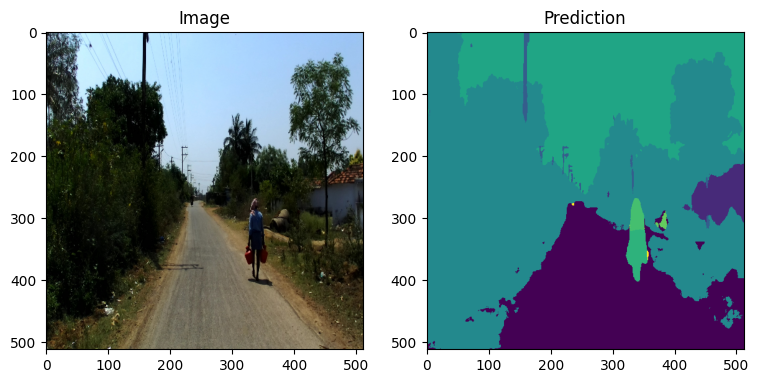

331
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


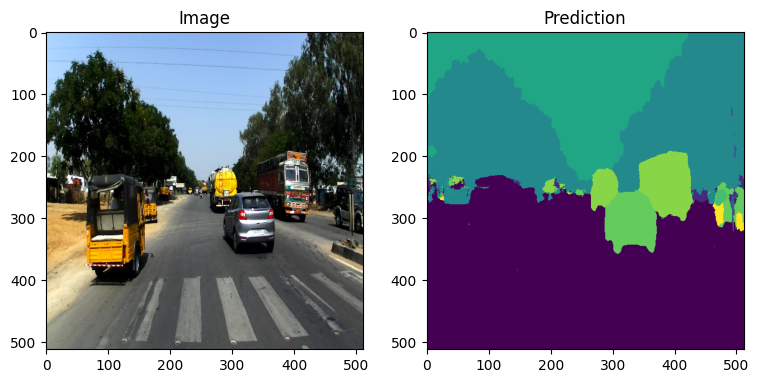

195
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


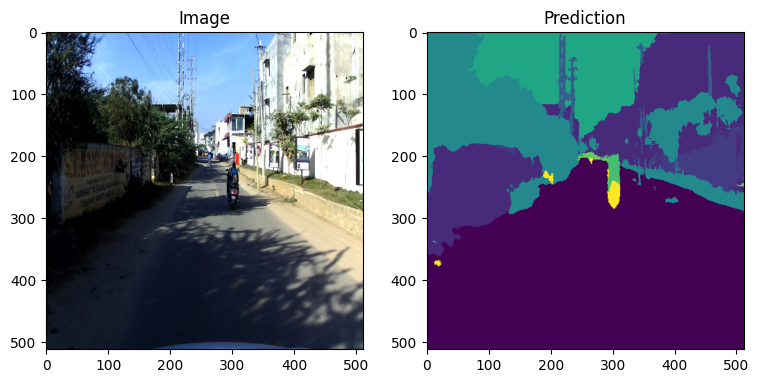

56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


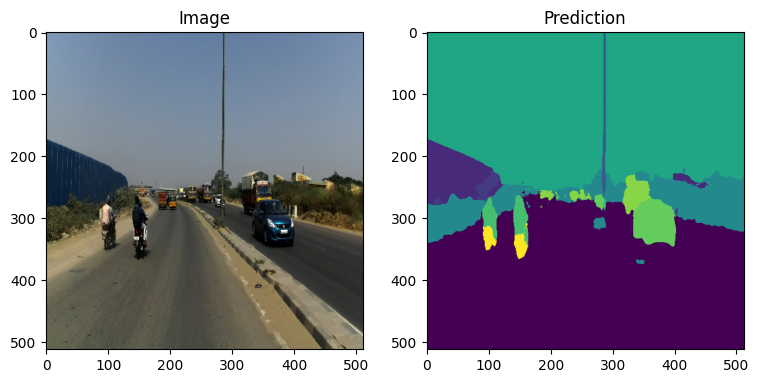

450
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


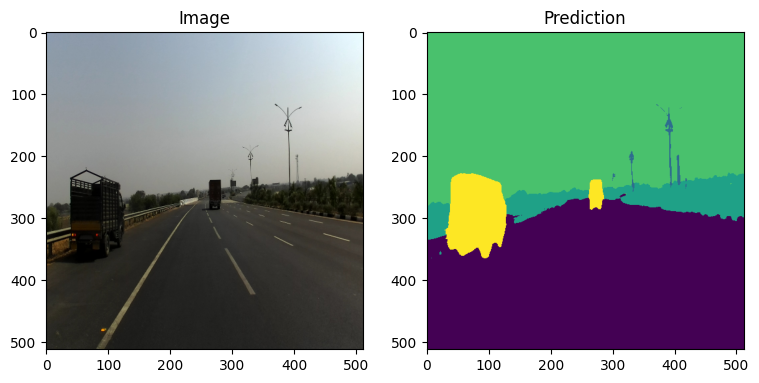

31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


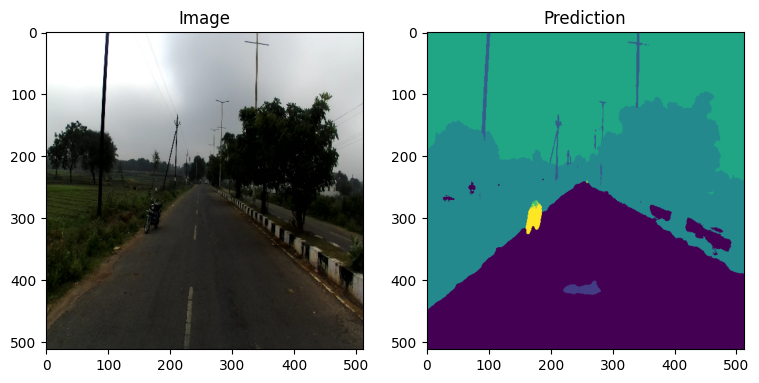

133
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


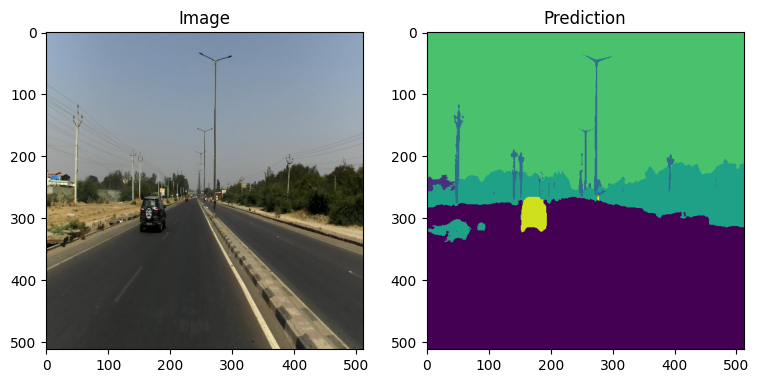

63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


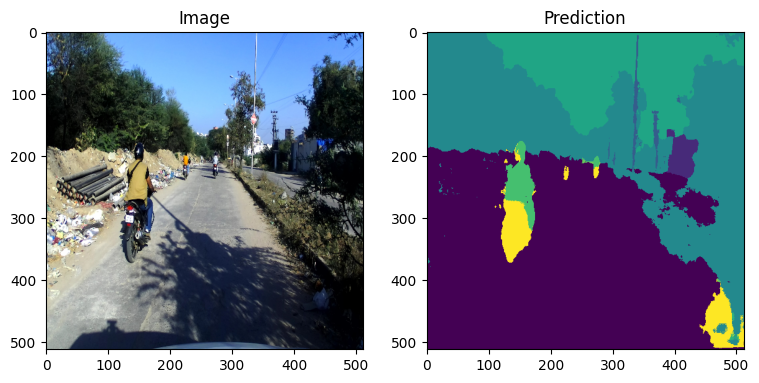

151
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


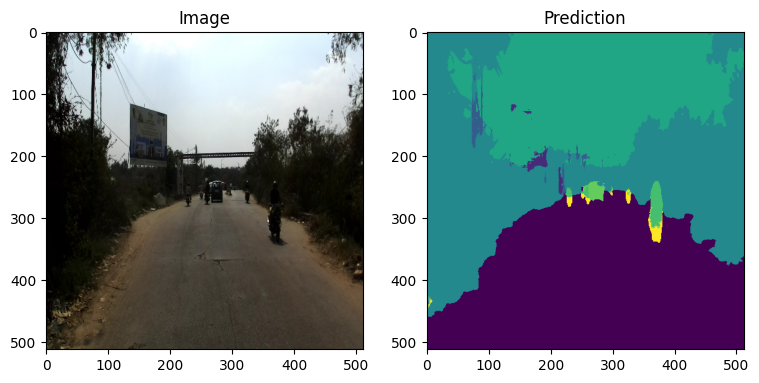

200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


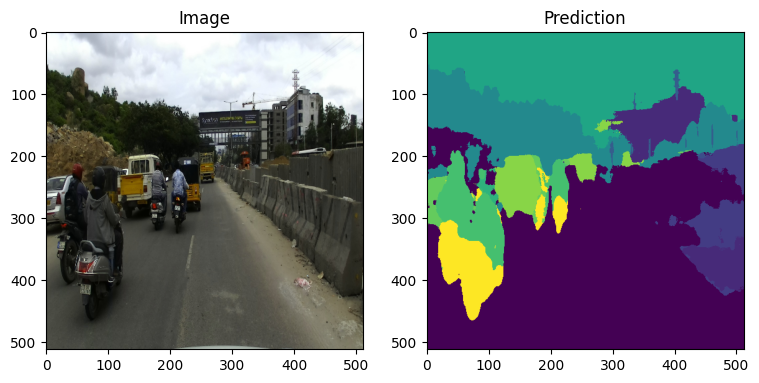

In [23]:
for i in np.random.randint(1,500, 10):
    print(i)
    visualize_sample(i)